In [1]:
import pandas as pd
from sklearn import model_selection
from matplotlib import pylab
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.base import *
from sklearn.linear_model import Lasso
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
#@title prepare
params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize': 22,
          'axes.labelsize': 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24
          }
pylab.rcParams.update(params)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


def replace_blood_type_with_bolean(data):
    data["blood_type1"] = (data["blood_type"].isin(["A+", "A-"])).astype(int)
    data["blood_type2"] = (data["blood_type"].isin(["O+", "O-"])).astype(int)
    data["blood_type3"] = (data["blood_type"].isin(["AB+", "AB-", "B+", "B-"])).astype(int)


def prepare_data(raw_data, new_data):
       # get training set
    trainingSet,_ = train_test_split(raw_data, test_size=0.2, random_state=69)
    # define what to do with cols
    to_delete = ["current_location", "symptoms", "blood_type", "pcr_date","patient_id"]
    to_standart_norm = ["happiness_score","num_of_siblings",'weight',   "household_income", "sugar_levels", "PCR_06", "PCR_08",'PCR_10','age', "conversations_per_day"]
    to_min_max_norm = [ "PCR_07",'sport_activity', 'PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05' ,"PCR_09"]

    # copy to return
    result_data = new_data.copy()

    # special cases
    replace_blood_type_with_bolean(result_data)
    result_data = pd.concat([result_data, result_data['symptoms'].str.get_dummies(sep=';')], axis=1)
    result_data["sex"].replace({"F": 1, "M": -1}, inplace=True)

    replace_blood_type_with_bolean(trainingSet)
    trainingSet = pd.concat([trainingSet, trainingSet['symptoms'].str.get_dummies(sep=';')], axis=1)
    trainingSet["sex"].replace({"F": 1, "M": -1}, inplace=True)
    # delete
    for col in to_delete:
        del result_data[col]
        del trainingSet[col]

    # standard_norm
    standard_scaler = StandardScaler()
    standard_scaler.fit(trainingSet[to_standart_norm])
    result_data[to_standart_norm] = standard_scaler.transform(result_data[to_standart_norm])

    # minmax_norm
    minmax_scaler = MinMaxScaler(feature_range=(-1,1))
    minmax_scaler.fit(trainingSet[to_min_max_norm])
    result_data[to_min_max_norm] = minmax_scaler.transform(result_data[to_min_max_norm])
    return result_data

In [3]:
#@title LinearRegressor
class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """

    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """
        m = len(y)
        b_array = np.ones((m,)) * b
        result = (1 / m) * (np.linalg.norm(np.dot(X,w) + b_array - y,axis=0)**2)
        return result

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        m = len(y)
        b_array = np.ones((m,)) * b
        objective = np.dot(X,w)+b_array-y
        g_w = (1/m)*2*np.dot(np.transpose(X),objective)
        g_b = (1/m)*2*np.sum(objective)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val=None, y_val=None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            g_w, g_b = self.gradient(self.w,self.b,batch_X,batch_y)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w-(self.lr*g_w)
            self.b = self.b-(self.lr*g_b)

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b, X, y))
                val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        b_array = np.ones((X.shape[0],)) * self.b
        y_pred = np.dot(X,self.w) + b_array

        return y_pred


In [4]:
#@title verify_gradient
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


In [5]:
#@title test_lr
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

In [6]:
#@title plot3d
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1, 
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    ax.view_init(elev=5., azim=45*i)
  
  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

In [7]:
from pandas.core.common import pipe
#@title helper functions
def tune_alpha(x,y,base_line=None,pipeline=None):
  alpha_test_values=np.logspace(-3,0,50)
  validation_errors=np.empty(alpha_test_values.shape)
  min_err=cross_validator['test_score'].mean()
  best_alpha=0.1
  for i,alpha in enumerate(alpha_test_values):
    current_regressor=Lasso(alpha=alpha)
    current_cross_validator=cross_validate(current_regressor,x,y,scoring='neg_mean_squared_error')
    validation_errors[i]=current_cross_validator['test_score'].mean()
    if current_cross_validator['test_score'].mean()>min_err:
      min_err=current_cross_validator['test_score'].mean()
      best_alpha=alpha

  plt.figure(figsize=(10,5))
  plt.semilogx(alpha_test_values,validation_errors,label= "lasso regressor validation mse")
  if base_line is not None:
    plt.axhline(y=base_line,label= "Dummy mse", color='r', linestyle='-')
  plt.legend()
  plt.title('tuning alpha for linear lasso regressor',fontsize=24)
  plt.xlabel('alpha values',fontsize=20)
  plt.ylabel('MSE',fontsize=20)
  plt.grid(color='b', linestyle='-', linewidth=0.5)
  print("optimal strengths is: {}, optimal validation error is: {}".format(best_alpha,min_err))

  return best_alpha

def print_mse_for_table(validator):
    print('the optimal train score is: ', validator['train_score'].mean())
    print('the optimal test score is: ', validator['test_score'].mean())

In [8]:
#@title import and process data
raw_data = pd.read_csv("https://raw.githubusercontent.com/NoaDickman/data_for_ml_wet3/main/HW3_data.csv")
train_set, test_set = train_test_split(raw_data, test_size=0.2, random_state=69)
processed_training = prepare_data(raw_data, train_set)
processed_test = prepare_data(raw_data, test_set)

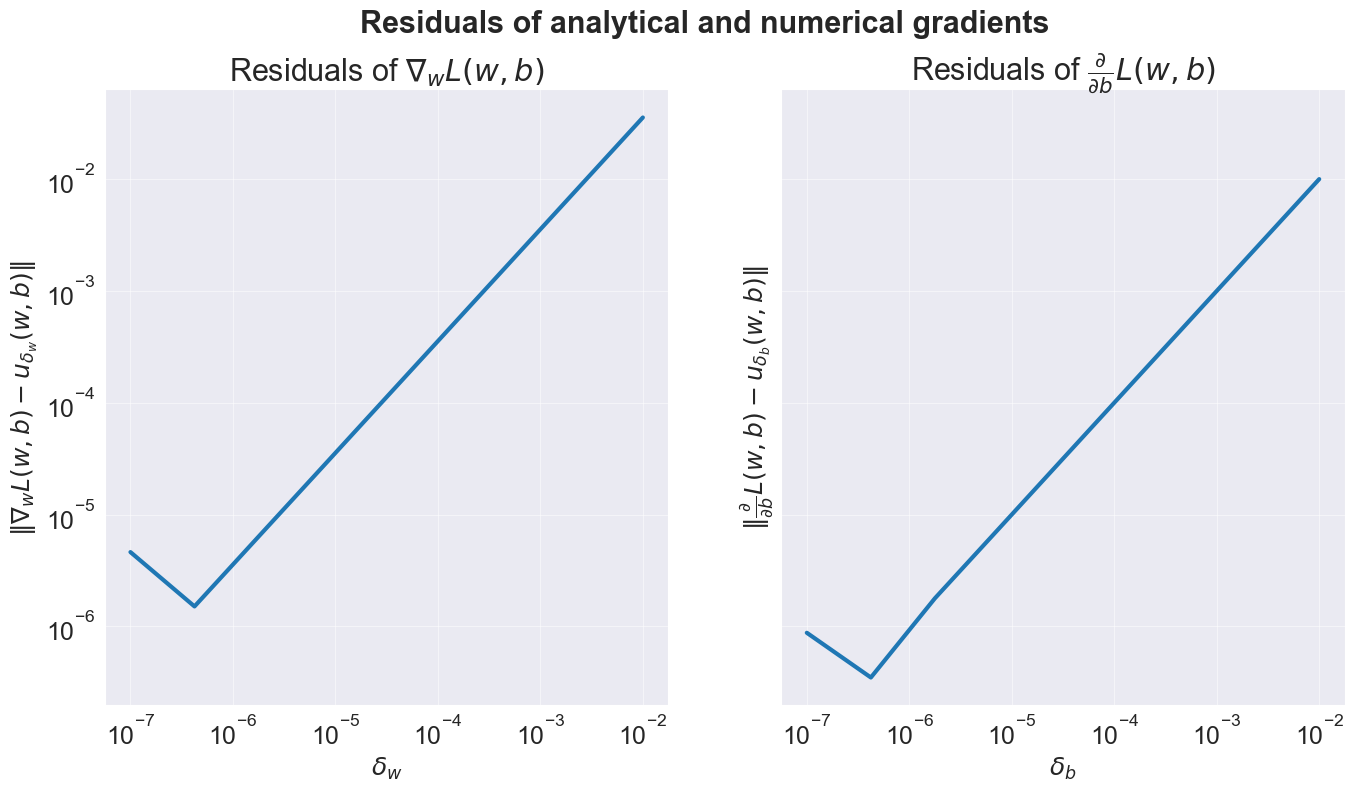

In [9]:
#@title Section1- Q2

section1_training_set, section1_validation_set = train_test_split(train_set, test_size=0.2, random_state=69)
section1_training_set, section1_validation_set =prepare_data(train_set, section1_training_set),prepare_data(train_set,section1_validation_set)
# verify croctness of loss and its gredient
x_train, y_train = section1_training_set.drop("contamination_level", axis=1).to_numpy(), section1_training_set[
    "contamination_level"].to_numpy()
compare_gradients(x_train, y_train, deltas=np.logspace(-7, -2, 9))


lr size = 1e-09, Best train loss = 395.4517091681105, Best validation loss = 415.2702277860635
lr size = 1e-08, Best train loss = 395.4198349368753, Best validation loss = 415.2383426519638
lr size = 1e-07, Best train loss = 395.10128706737066, Best validation loss = 414.91968314391
lr size = 1e-06, Best train loss = 391.9351725565088, Best validation loss = 411.75219283289334
lr size = 1e-05, Best train loss = 362.13277436075214, Best validation loss = 381.9116194384397
lr size = 0.0001, Best train loss = 191.60367987943587, Best validation loss = 209.67139908662506
lr size = 0.001, Best train loss = 99.48949370985397, Best validation loss = 114.69912422807477
lr size = 0.01, Best train loss = 95.1149294088126, Best validation loss = 113.79048710779726
lr size = 0.1, Best train loss = 96.41296703439482, Best validation loss = 112.50909286966665


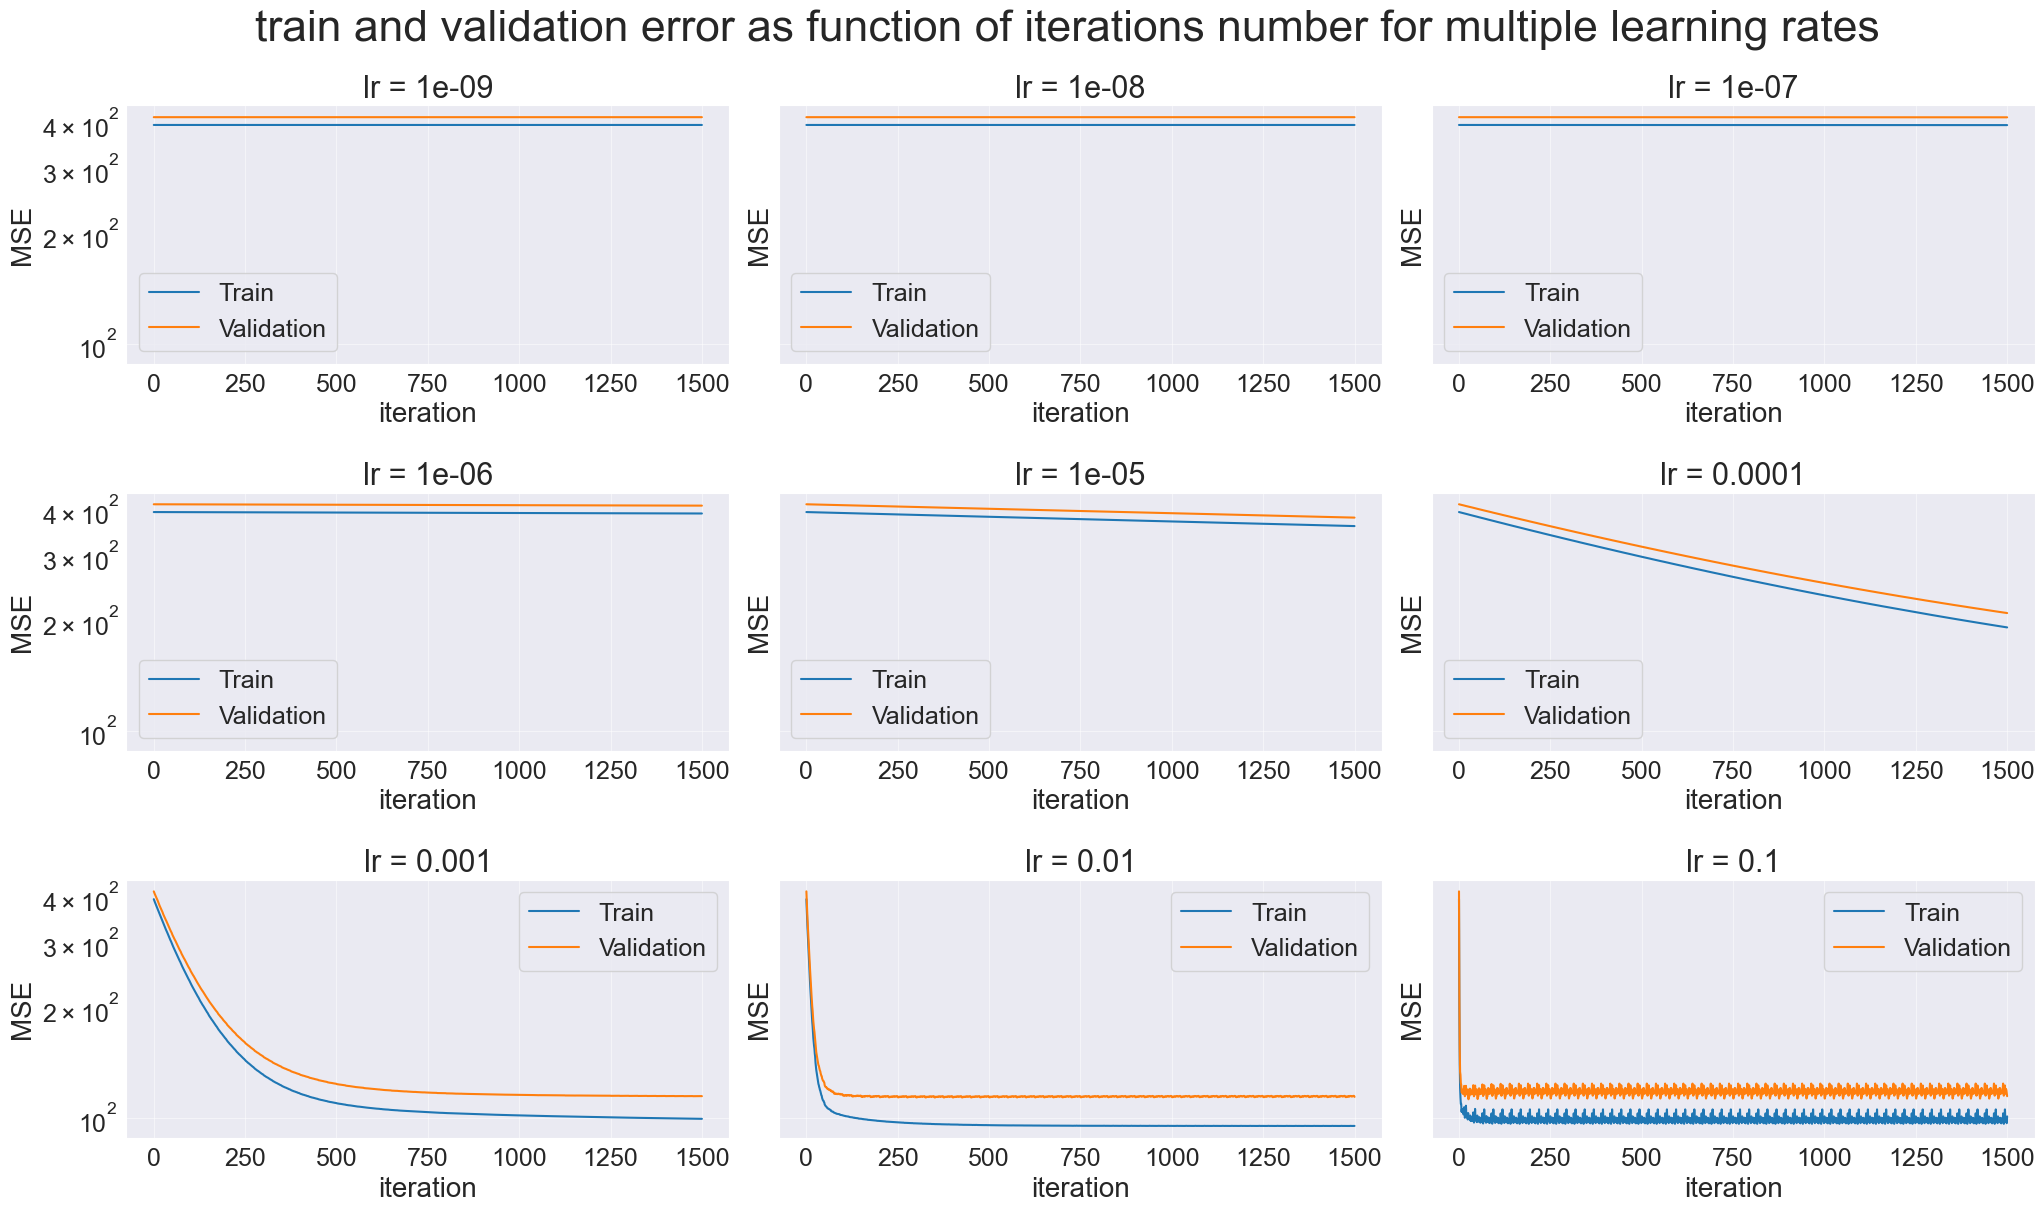

In [10]:
#@title Section 1- Q3
x_val,y_val=section1_validation_set.drop("contamination_level", axis=1).to_numpy(), section1_validation_set["contamination_level"].to_numpy()
test_lr(x_train,y_train,x_val,y_val,"train and validation error as function of iterations number for multiple learning rates")

In [11]:
#@title Q4- dummy regressoras baseline

section2_x_training,section2_y_training=processed_training.drop("contamination_level", axis=1).to_numpy(), processed_training["contamination_level"].to_numpy()
dummy_regressor=DummyRegressor()
cross_validator=cross_validate(dummy_regressor,section2_x_training,section2_y_training,cv=5 ,return_train_score=True,scoring='neg_mean_squared_error')
print_mse_for_table(cross_validator)
s6_dummy_linear_regressor=DummyRegressor()
s6_dummy_linear_regressor.fit(section2_x_training,section2_y_training)


the optimal train score is:  -108.86631952493619
the optimal test score is:  -108.94409420045997


DummyRegressor()

the optimal train score is:  -97.91591342851207
the optimal test score is:  -103.37941920654453


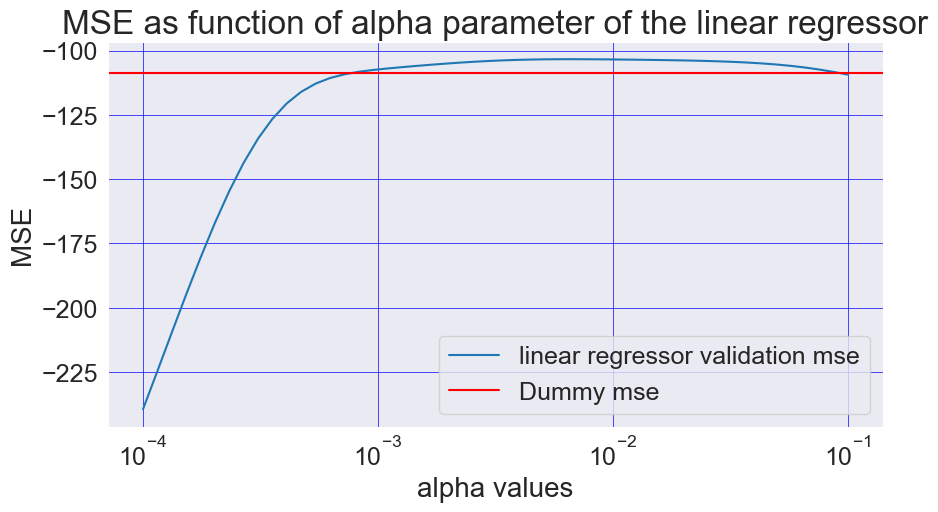

In [12]:
#@title Q5- linear model
# tuning lr

lr_test_values=np.logspace(-4,-1,50)
validation_errors=np.empty(lr_test_values.shape)
min_err=cross_validator['test_score'].mean()
best_lr=0.1
for i,lr in enumerate(lr_test_values):
    current_regressor=LinearRegressor(lr=lr)
    current_cross_validator=cross_validate(current_regressor,section2_x_training,section2_y_training,scoring='neg_mean_squared_error')
    validation_errors[i]=current_cross_validator['test_score'].mean()
    if current_cross_validator['test_score'].mean()>min_err:
        min_err=current_cross_validator['test_score'].mean()
        best_lr=lr

plt.figure(figsize=(10,5))
plt.semilogx(lr_test_values,validation_errors,label= "linear regressor validation mse")
plt.axhline(y=cross_validator['train_score'].mean(),label= "Dummy mse", color='r', linestyle='-')
plt.legend()
plt.title('MSE as function of alpha parameter of the linear regressor',fontsize=24)
plt.xlabel('alpha values',fontsize=20)
plt.ylabel('MSE',fontsize=20)
plt.grid(color='b', linestyle='-', linewidth=0.5)

#evaluate tuned regressor
tuned_regressor=LinearRegressor(best_lr)
cross_validator_q5=cross_validate(tuned_regressor,section2_x_training,section2_y_training,scoring='neg_mean_squared_error',return_train_score=True)
print_mse_for_table(cross_validator_q5)



In [13]:
#@title Task for sec6
s6_linear_regressor=LinearRegressor(best_lr)
s6_linear_regressor.fit(section2_x_training,section2_y_training)

LinearRegressor(lr=0.006866488450042998)

optimal strengths is: 0.32374575428176433, optimal validation error is: -101.85264192483093
the optimal train score is:  -100.34911032577348
the optimal test score is:  -101.85264192483093


,name,coefficient_value
0,age,2.429947
1,low_appetite,1.740277
2,fever,0.196121
3,cough,0.006195
4,blood_type3,0.004216


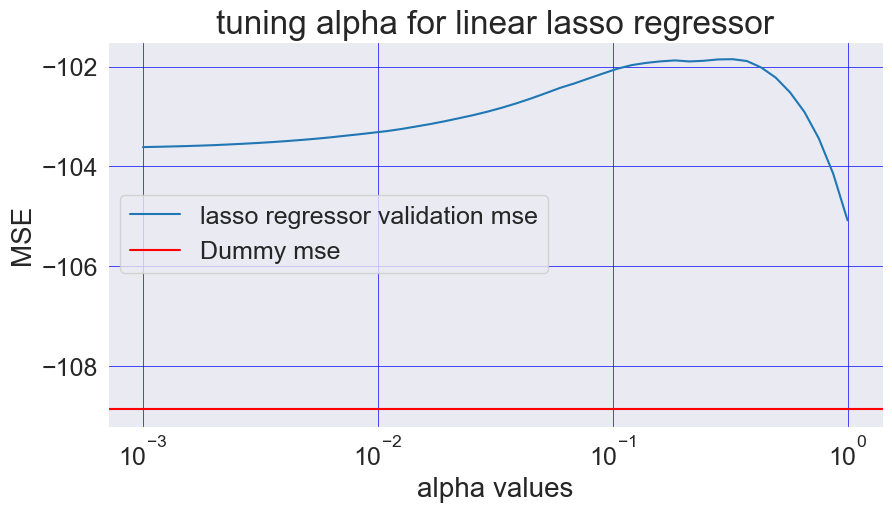

In [14]:
#@title section 3
best_alpha=tune_alpha(section2_x_training,section2_y_training,cross_validator['train_score'].mean())

#evaluate tuned regressor
tuned_lasso_regressor=Lasso(best_alpha)
cross_validator_q5=cross_validate(tuned_lasso_regressor,section2_x_training,section2_y_training,scoring='neg_mean_squared_error',return_train_score=True)
print('the optimal train score is: ', (cross_validator_q5['train_score'].mean()))
print('the optimal test score is: ', cross_validator_q5['test_score'].mean())

#@title Task for sec6
s6_lasso_regressor=Lasso(best_alpha)
s6_lasso_regressor.fit(section2_x_training,section2_y_training)

#Q9
w_abs=abs(s6_lasso_regressor.coef_)
largest_coefficients_inx = np.argsort(abs(w_abs))
largest_coefficients_values = np.sort(abs(w_abs))[::-1]
largest_coefficients_names = processed_training.columns.drop("contamination_level")[largest_coefficients_inx]
coeff_df = pd.DataFrame({'name': largest_coefficients_names, 'coefficient_value': largest_coefficients_values})
coeff_df.head(5)


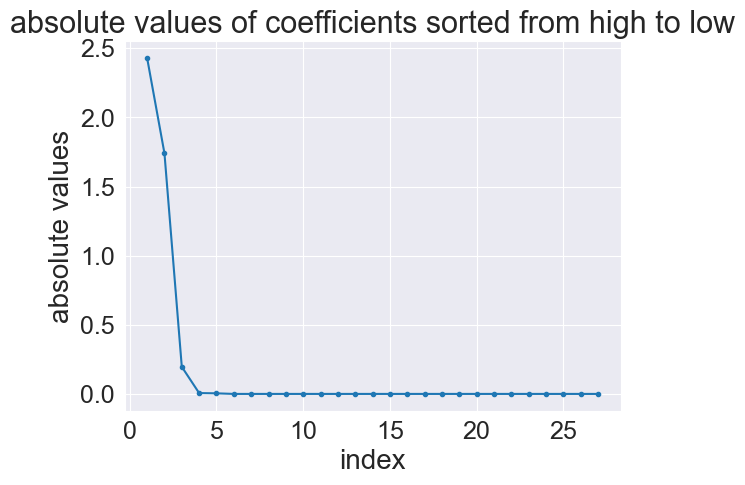

In [15]:
#Q10
plt.plot(np.linspace(1,27,27), largest_coefficients_values, '.-')
plt.grid()
plt.xlabel("index")
plt.ylabel("absolute values")
plt.title("absolute values of coefficients sorted from high to low")
plt.grid()
plt.show()

C:\Users\t-noadickman\AppData\Local\Temp\ipykernel_27540\714724663.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


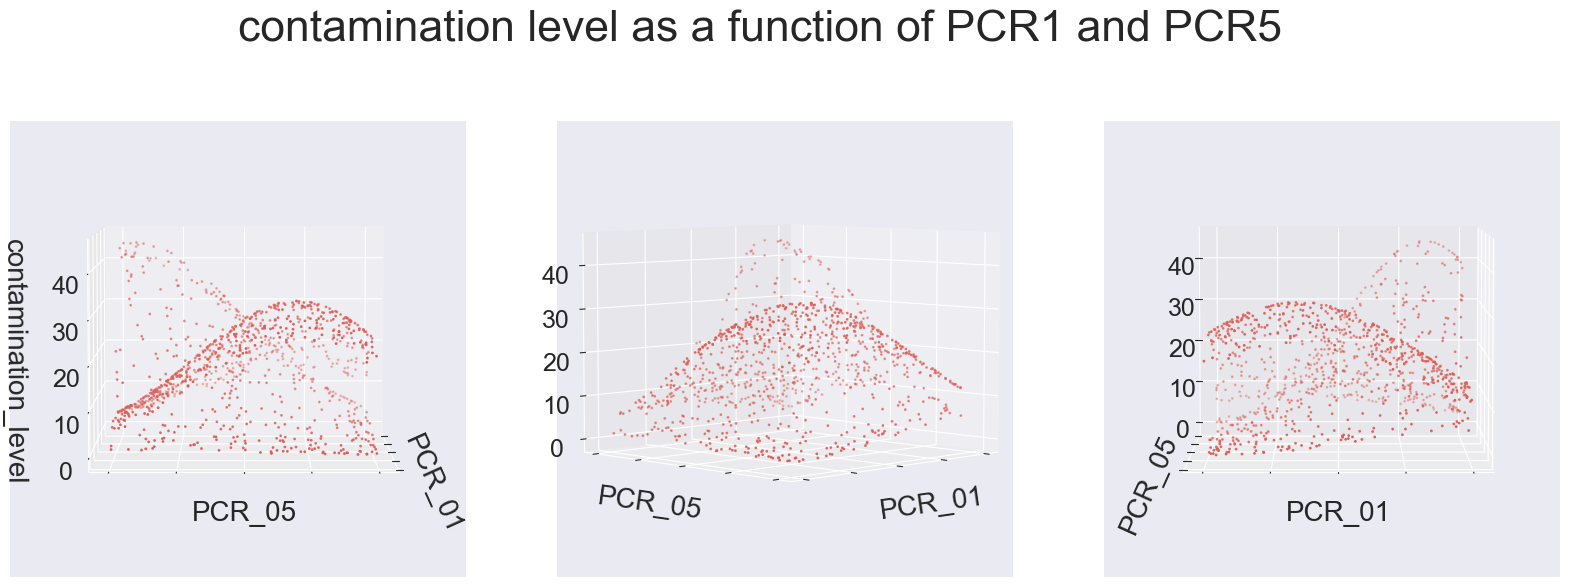

optimal strengths is: 0.0015264179671752333, optimal validation error is: -105.20617296894997


C:\Users\t-noadickman\AppData\Local\Temp\ipykernel_27540\714724663.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


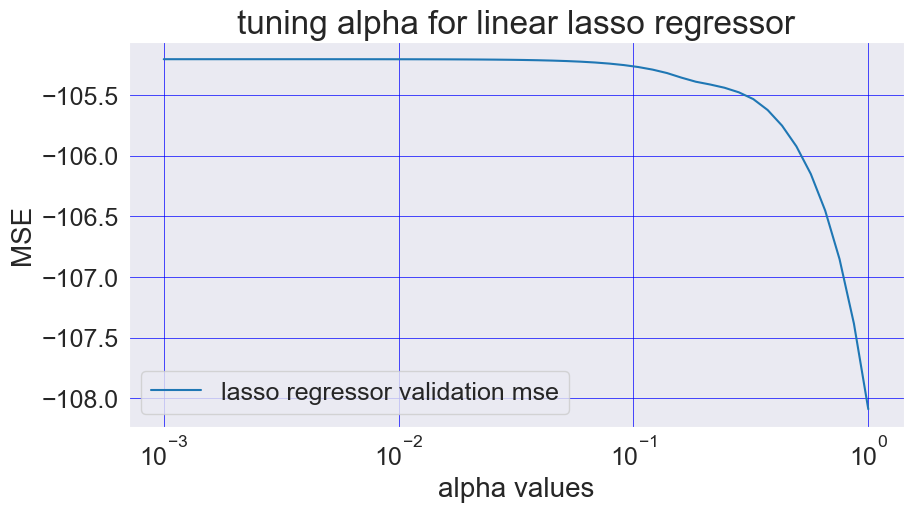

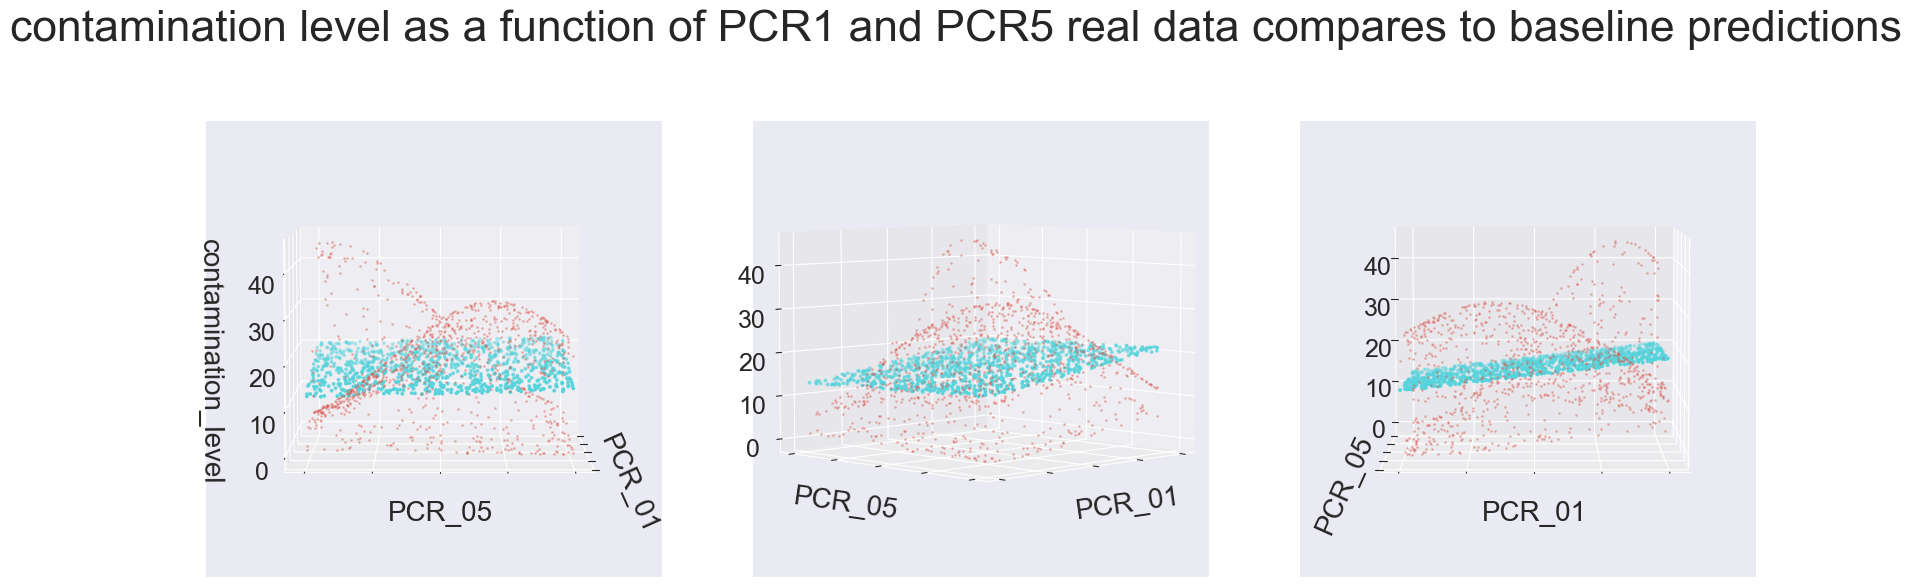

In [16]:
#@title section 4
x_train_for_s4,y_train_for_s4=processed_training[["PCR_01","PCR_05"]].to_numpy(),processed_training["contamination_level"].to_numpy()
x,y,z="PCR_01","PCR_05","contamination_level"
sub_df=processed_training[[x,y,z]]
#Q13
plot3d(sub_df,x,y,z,"contamination level as a function of PCR1 and PCR5")
#Q14
tuned_alpha_s4=tune_alpha(x_train_for_s4,y_train_for_s4)
lasso_regressor_q14=Lasso(tuned_alpha_s4)
lasso_regressor_q14.fit(x_train_for_s4,y_train_for_s4)
#Q15
predictions_q15=lasso_regressor_q14.predict(x_train_for_s4)
plot3d(sub_df,x,y,z,"contamination level as a function of PCR1 and PCR5 real data compares to baseline predictions",predictions_q15)

C:\Users\t-noadickman\AppData\Local\Temp\ipykernel_27540\1474243337.py:1: DeprecationWarning: Please use `inf` from the `scipy.optimize` namespace, the `scipy.optimize.minpack` namespace is deprecated.
  from scipy.optimize.minpack import inf


optimal strengths is: 1e-11, optimal validation error is: -93.6478198024432


C:\Users\t-noadickman\AppData\Local\Temp\ipykernel_27540\714724663.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


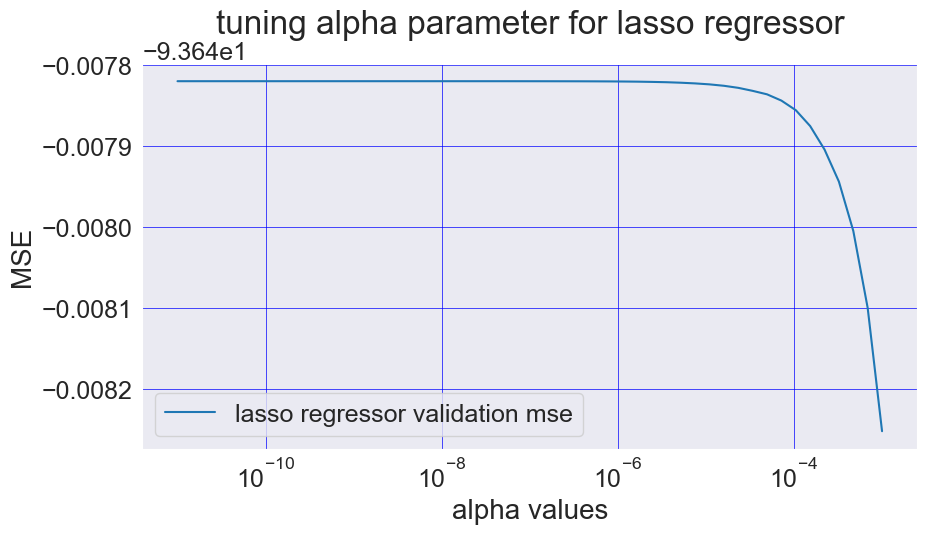

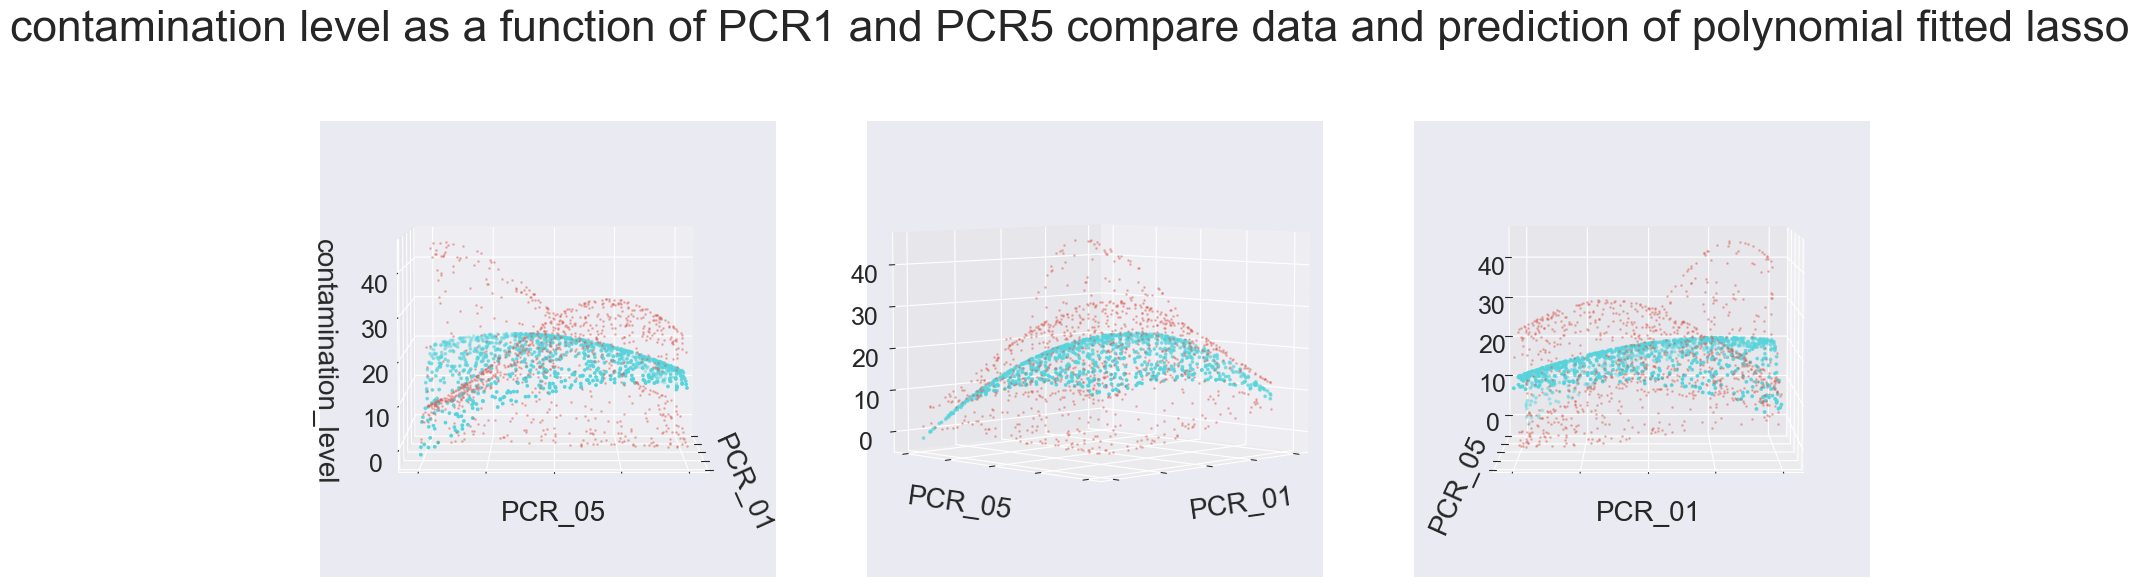

In [17]:
from scipy.optimize.minpack import inf
#@title Improving with polonomial fitting


alpha_test_values=np.logspace(-11,-3,50)
validation_errors=np.empty(alpha_test_values.shape)
# min_err=cross_validator['test_score'].mean()
best_alpha=0.1
min_err=-inf
for i,alpha in enumerate(alpha_test_values):
  current_regressor=Pipeline([('feature_mapping', PolynomialFeatures(degree=2)),('normalization', MinMaxScaler()),('Lasso', Lasso (alpha=alpha))])
  current_cross_validator=cross_validate(current_regressor,x_train_for_s4,y_train_for_s4,scoring='neg_mean_squared_error')
  validation_errors[i]=current_cross_validator['test_score'].mean()
  if current_cross_validator['test_score'].mean()>min_err:
    min_err=current_cross_validator['test_score'].mean()
    best_alpha=alpha

plt.figure(figsize=(10,5))
plt.semilogx(alpha_test_values,validation_errors,label= "lasso regressor validation mse")
# plt.axhline(y=base_line,label= "Dummy mse", color='r', linestyle='-')
plt.legend()
plt.title('tuning alpha parameter for lasso regressor',fontsize=24)
plt.xlabel('alpha values',fontsize=20)
plt.ylabel('MSE',fontsize=20)
plt.grid(color='b', linestyle='-', linewidth=0.5)
print("optimal strengths is: {}, optimal validation error is: {}".format(best_alpha,min_err))

#q18
s6_lasso_linear_regressor = Pipeline([('feature_mapping', PolynomialFeatures(degree=2)),('normalization', MinMaxScaler()),('Lasso', Lasso (alpha=best_alpha))])
s6_lasso_linear_regressor.fit(x_train_for_s4,y_train_for_s4)
q18_predictions=s6_lasso_linear_regressor.predict(x_train_for_s4)
plot3d(sub_df,x,y,z,"contamination level as a function of PCR1 and PCR5 compare data and prediction of polynomial fitted lasso",q18_predictions)

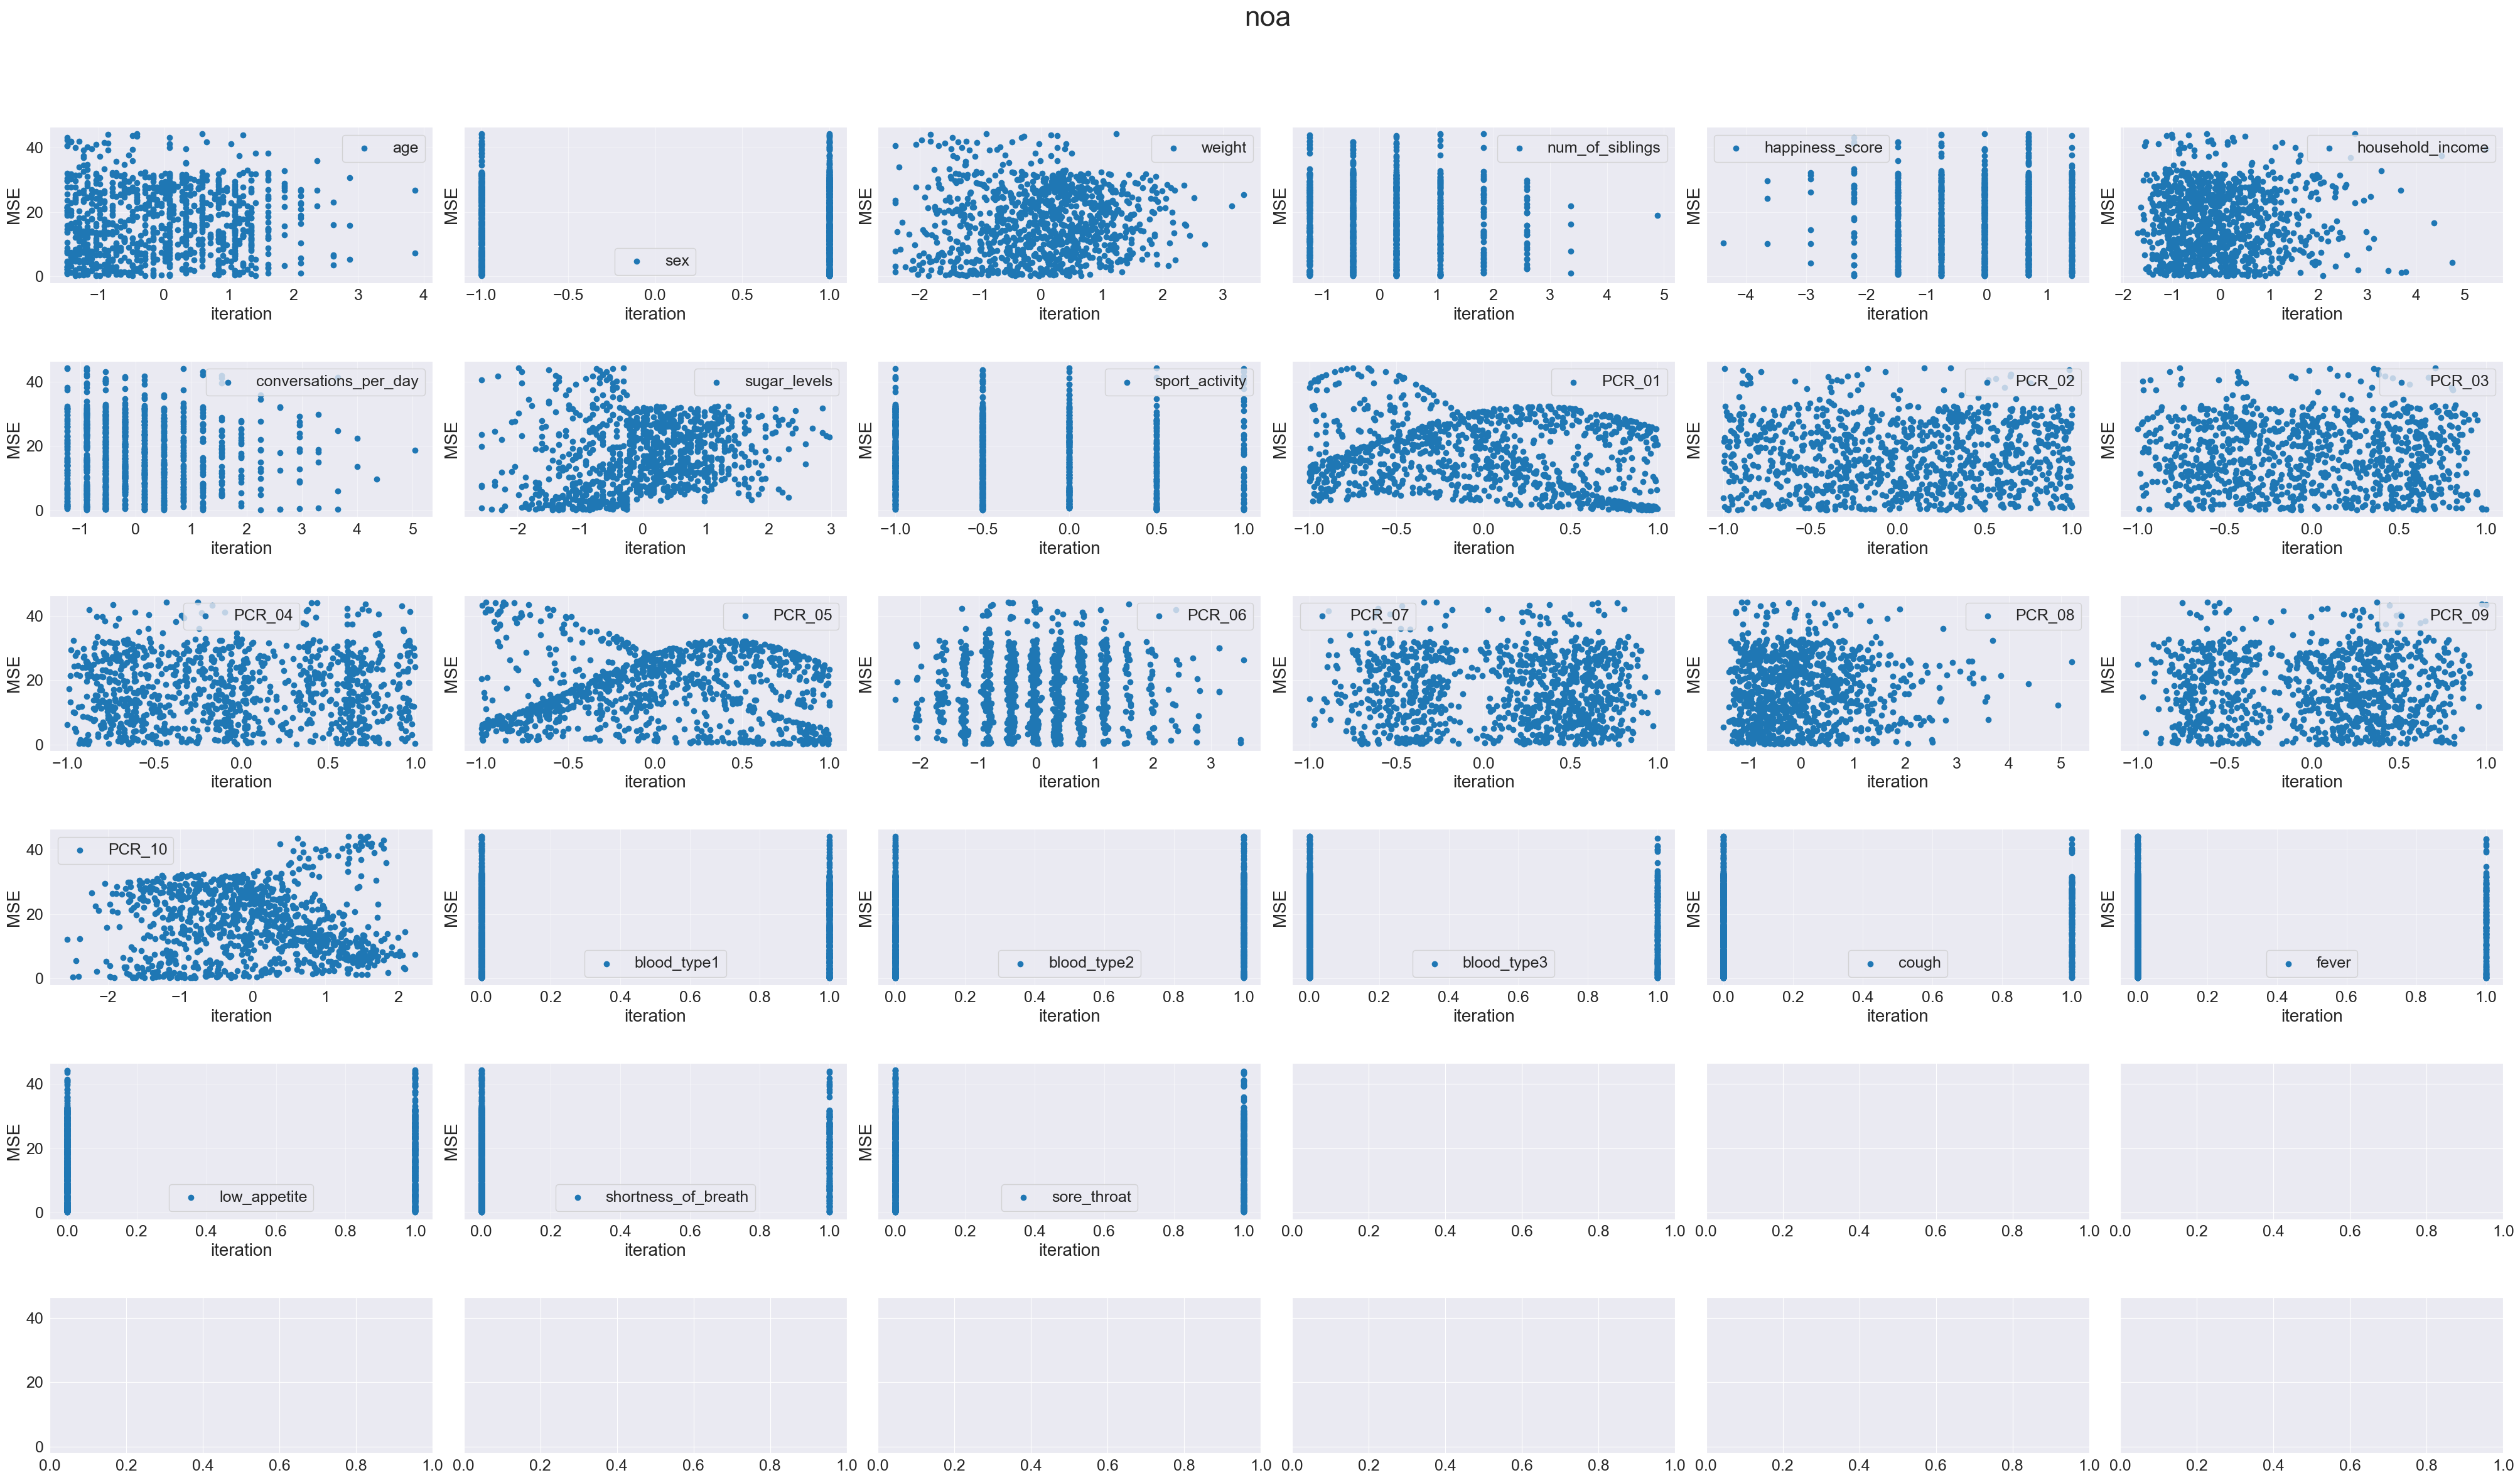

In [18]:
#@title Section 5- helper
fig, axs = plt.subplots(6, 6, sharey=True, figsize=(40, 24))
plt.suptitle("noa", fontsize=32)
plt.tight_layout()
fig.subplots_adjust(hspace=0.5, top=0.9)

axs = np.ravel(axs)
col_names=processed_training.drop("contamination_level",axis=1).columns
for i in range(27):
  axs[i].scatter(section2_x_training[:,i], section2_y_training, label=col_names[i])
  axs[i].grid(alpha=0.5)
  axs[i].legend()
  axs[i].set_xlabel('iteration')
  axs[i].set_ylabel('MSE')


In [20]:
from numpy.core.fromnumeric import mean
#@title section 5
x_s5,y_s5= section2_x_training,section2_y_training
features_for_polynomial=[i for i,val in enumerate(col_names) if val in ["PCR_01","PCR_05"] ]
features_for_rbf=[i for i,val in enumerate(col_names) if val in ["PCR_10","sugar_levels","weight","PCR_06"] ]

# tuning gamma
gamma_test_values=np.logspace(-2,2,20)


best_gammas=[]
for f in range(4):
  best_gamma=0.1
  min_err=-inf
  for i,gamma in enumerate(gamma_test_values):
    current_rfr=Pipeline([('feature_mapping', ColumnTransformer([("poly",PolynomialFeatures(degree=2),features_for_polynomial),("rbf",RBFSampler(random_state=69,gamma= gamma),features_for_rbf)])),('normalization', ColumnTransformer([("minMax",MinMaxScaler(),features_for_rbf)])),('RFR',RandomForestRegressor ())])
    current_cross_validator=cross_validate(current_rfr,x_s5,y_s5,scoring='neg_mean_squared_error')
    validation_errors[i]=current_cross_validator['test_score'].mean()
    if current_cross_validator['test_score'].mean()> min_err:
      min_err=current_cross_validator['test_score'].mean()
      best_gamma=gamma
  best_gammas.append(best_gamma)


pipe=Pipeline([('feature_mapping', ColumnTransformer([("poly",PolynomialFeatures(degree=2),features_for_polynomial),*(("rbf_"+str(i),RBFSampler(random_state=69,gamma=best_gammas[i]),[features_for_rbf[i]]) for i in range(len(features_for_rbf)) )],remainder="passthrough")),('normalization', ColumnTransformer([("minMax",MinMaxScaler(),features_for_rbf)],remainder="passthrough")),('RFR',RandomForestRegressor())])
cross_validator=cross_validate(pipe,x_s5,y_s5,scoring='neg_mean_squared_error')


In [ ]:
#@title Q23
n_estimators_range= range(100,200,10)
min_samples_leaf_range= range(1,10)

param_dict = {'RFR__n_estimators': n_estimators_range, 'RFR__min_samples_leaf': min_samples_leaf_range}
grid = GridSearchCV(estimator=pipe, param_grid=param_dict, return_train_score=True,scoring='neg_mean_squared_error')
grid.fit(x_s5, y_s5)

print("Best parameters:", grid.best_params_)
print("Mean test score:", grid.cv_results_['mean_test_score'].mean())
print("Mean train score:", grid.cv_results_['mean_train_score'].mean())

In [ ]:
tune_train = pd.pivot_table(pd.DataFrame(grid.cv_results_), values='mean_train_score', index='param_RFR__n_estimators', columns='param_RFR__min_samples_leaf')

fig, ax = plt.subplots(figsize=(15, 10))
train_subplot = sns.heatmap(tune_train, annot=True, linewidths=1, ax=ax, fmt='.4g', cmap='viridis', annot_kws={'size': 15}, xticklabels=True, yticklabels=True)
plt.title("Mean Train Accuracy as a function of num of estimators and Min Samples Leaf")
plt.xlabel("Min Samples Leaf")
plt.ylabel("num of estimators")
plt.show()

tune_test = pd.pivot_table(pd.DataFrame(grid.cv_results_), values='mean_test_score', index='param_RFR__n_estimators', columns='param_RFR__min_samples_leaf')

fig, ax = plt.subplots(figsize=(15, 10))
test_subplot = sns.heatmap(tune_test, annot=True, linewidths=1, ax=ax, fmt='.4g', cmap='viridis',annot_kws={'size': 15},xticklabels=True, yticklabels=True)
plt.title("Mean Validation Accuracy as a function of num of estimators and Min Samples Leaf")
plt.xlabel("Min Samples Leaf")
plt.ylabel("num of estimators")

plt.show()

In [ ]:
# find the MSE fir optimal RFR
s6_pipe=Pipeline([('feature_mapping', ColumnTransformer([("poly",PolynomialFeatures(degree=2),features_for_polynomial),*(("rbf_"+str(i),RBFSampler(random_state=69,gamma=best_gammas[i]),[features_for_rbf[i]]) for i in range(len(features_for_rbf)) )],remainder="passthrough")),('normalization', ColumnTransformer([("minMax",MinMaxScaler(),features_for_rbf)],remainder="passthrough")),('RFR',RandomForestRegressor())])
# s6_pipe.set_params(**grid.best_params_)
tuned_rfr_cross_validator=cross_validate(s6_pipe,x_s5,y_s5,scoring='neg_mean_squared_error',return_train_score=True)


print_mse_for_table(tuned_rfr_cross_validator)


s6_rf_regressor=s6_pipe.fit(x_s5,y_s5)

SECTION 6

In [ ]:
from sklearn.metrics import mean_squared_error
x_test,y_test=processed_test.drop("contamination_level",axis=1).to_numpy(),processed_test["contamination_level"].to_numpy()
def get_error(estimator):
    y_predict=estimator.predict(x_test)
    print(mean_squared_error(y_test,y_predict))
get_error(s6_dummy_linear_regressor)
get_error(s6_linear_regressor)
get_error(s6_lasso_regressor)
get_error(s6_rf_regressor)